# Illustration of FedDifPrivModels 'package'

Import packages

In [27]:
from FedDifPrivModels.FedDataset import FedDataset
from FedDifPrivModels.FedAllInOnePGM import FedAllInOnePGM
from FedDifPrivModels.FedAdapIterPGM import FedAdapIterPGM
from FedDifPrivModels.FedDPCTGAN import FedDPCTGAN
from FedDifPrivModels.Evaluation import Evaluation
from FedDifPrivModels.Utils import FL_split_data, mu_from_eps_delta, eps_from_mu_delta
import numpy as np
import pandas as pd

Set seed

In [28]:
#set seed
seed = 1234
rng = np.random.default_rng(seed)

 Get all information needed to apply our models

In [29]:
#get adult dataset
adult_raw = pd.concat([
    pd.read_csv("C:/Users/erkjrv/OneDrive - TNO/wp3-federated-synthetic-data/thesis_julian/original_data/adult/adult.csv", 
    usecols=["age","workclass","fnlwgt","education-num","marital-status", "occupation",
    "relationship","race","sex","capital-gain","capital-loss","hours-per-week",
    "native-country","income>50K"]),
    pd.read_csv("C:/Users/erkjrv/OneDrive - TNO/wp3-federated-synthetic-data/thesis_julian/original_data/adult/adult_test.csv", 
    usecols=["age","workclass","fnlwgt","education-num","marital-status", "occupation",
    "relationship","race","sex","capital-gain","capital-loss","hours-per-week",
    "native-country","income>50K"], escapechar='.')], ignore_index=True)

#sample 40000 observations
adult_raw  = adult_raw.iloc[rng.choice(len(adult_raw), size = 40000, replace=False),:].reset_index(drop=True)

#set datatypes
lDataTypes = ["numerical","categorical", "numerical", "ordinal", "categorical", 
                "categorical", "categorical", "categorical", "categorical", "mixed",
                "mixed", "numerical", "categorical", "categorical"]

#ordinal variables should be 0,1,...,n-1
adult_raw['education-num'] = adult_raw['education-num'] - 1

#get min and max of every column (of continuous, ordinal or mixed data)
minInfo = adult_raw.min()
maxInfo = adult_raw.max()

#get the minimum and maximum value for continuous data, unique value for categorical variables
diMinMaxInfo = dict()
diCatUniqueValuesInfo = dict()
for d in range(len(lDataTypes)):
    sVarName = adult_raw.columns[d]
    if (lDataTypes[d] == "numerical") or (lDataTypes[d] == "ordinal") or (lDataTypes[d] == "mixed"):
        #get minimum and maximum info
        diMinMaxInfo[sVarName] = [minInfo[sVarName], maxInfo[sVarName]]
    else:
        #get names info
        diCatUniqueValuesInfo[sVarName] = list(pd.unique(adult_raw[sVarName]))#list(set(adult_raw[sVarName].values))  

#set info of number of decimals for continuous (and ordinal) variables.  
delimiterInfo = { "age": 0, "fnlwgt": 0, "capital-gain":0, "capital-loss":0, "hours-per-week":0}

#set y variable name
sYname = 'income>50K'

#set mapper for binary dependent variable (only for splitting the dataset in heterogeneous setting)
diMapper = {" <=50K": 0, " >50K": 1}

Split data to get a Federated setting

In [30]:
#set number of clients
iC = 5

#set fraction of number of observations for each client (list of length iC that sums to 1)
lFrac = iC * [1/iC]

#Create (potentially) heterogeneous data by splitting on a binary y variable. yFrac gives the relative weight of y=1 observations in each dataset. 
#For example, [5,3,2] means 50% of y=1 in dataset client 1, 30% in client 3, etc. Gives an argumentError if number of y =1 observations in a client 
#dataset should be larger than the size of this dataset. (Does not need to sum to 1)
yFrac = [1.0, 1.0, 1.0, 1.0, 1.0]

#set fraction training data
dTrainFrac = 0.75

#split data, get list of train and test datasets for each client 
lClientTrainDataRaw, lClientTestDataRaw = FL_split_data(adult_raw, dTrainFrac = dTrainFrac, iC = iC, lFrac = lFrac, sYname = sYname, yFrac = yFrac, rng = rng, diMapper = diMapper)

#for evaluation purposes,  get the total training and test dataset
dfTotalTrainData = pd.concat(lClientTrainDataRaw)
dfTotalTestData = pd.concat(lClientTestDataRaw)

Define privacy Parameters

In [1]:
#FedDifPrivModels works with mu-GDP. So if we have standard eps-delta-DP, we have to transform
dEps = 0.1
dDelta = 10**-9
dMu = mu_from_eps_delta(dEps, dDelta)[0] #0.6477
print(dMu)

NameError: name 'mu_from_eps_delta' is not defined

Fit a simple FedDPPGM Model (tree specification)

In [7]:
#define object (number of bins for continuous, mixed variables = 2^(iMaxRoundsNumerical + 1))
fedAllInOnePGM = FedAllInOnePGM(dMu = dMu, rng = rng, bVerbose=True, iMaxRoundsNumerical=4, bCombineLevels = False)

#fit model. Fitting also create the federated dataset, so we also supply diMinMaxinfo, diCatUnqiqueValuesInfo and lDataTypes.
# model is the graphical model. fedDataset contains the discritized data and other info on the federated dataset.
models, fedDataset = fedAllInOnePGM.fit(lClientTrainDataRaw, diMinMaxInfo = diMinMaxInfo, diCatUniqueValuesInfo = diCatUniqueValuesInfo, lDataTypes = lDataTypes)

start discritization and initial measurement
start initial estimation
start second selection step
start final estimation
Total clique size: 2217
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.01		10831.28		443704.20		0.00
50.00		0.78		4347.81		11903.79		0.00
100.00		1.57		2552.07		2484.49		0.00
150.00		2.30		1950.31		1316.71		0.00
200.00		3.02		1666.62		966.21		0.00
250.00		3.78		1535.59		825.08		0.00
300.00		4.52		1435.75		742.10		0.00
350.00		5.30		1383.19		687.94		0.00
400.00		6.03		1338.90		651.85		0.00
450.00		6.77		1306.74		624.74		0.00
500.00		7.53		1280.96		607.20		0.00
550.00		8.30		1270.13		596.86		0.00
600.00		9.11		1258.63		587.42		0.00
650.00		9.84		1253.62		580.05		0.00
700.00		10.66		1251.80		575.65		0.00
750.00		11.44		1247.89		572.99		0.00
800.00		12.25		1242.31		570.21		0.00
850.00		13.05		1240.24		568.03		0.00
900.00		13.83		1239.63		566.19		0.00
950.00		14.58		1238.47		564.85		0.00
1000.00		15.34		1237.60		563.69		0.00
1050.00		16.15		1235.55		562.60		0.00
1

Generate data

In [8]:
dfSynth = models.synthetic_data(rows = 10000).df
dfSynth

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income>50K
0,7,0,2,6,2,6,4,0,1,0,0,1,0,0
1,15,0,2,12,2,4,1,0,1,3,14,12,0,1
2,18,0,1,5,0,2,0,0,0,0,0,12,0,1
3,0,0,0,6,1,6,2,0,1,0,0,12,0,0
4,8,0,4,10,0,0,0,0,0,0,0,14,29,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,11,1,2,8,0,6,5,0,1,0,0,7,0,1
9996,15,0,1,12,1,0,2,0,0,0,0,14,0,0
9997,3,0,2,9,1,8,2,0,1,0,0,12,0,0
9998,6,0,1,8,0,0,0,1,0,0,0,12,0,1


Transform data to original space. (Function was made for a more general setting, now it looks ugly)

In [11]:
dfSynthOrig = FedDataset.transform_to_original_space(dfSynth, lDataTypes, diBins = fedDataset.diBins, diDefaultBins = fedDataset.diBins, delimiterInfo = delimiterInfo, rng = rng) 
dfSynthOrig

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income>50K
0,33,Private,132848,7,Divorced,Other-service,Unmarried,White,Female,0.0,0.0,6,United-States,<=50K
1,52,Private,135306,13,Divorced,Sales,Not-in-family,White,Female,7865.0,1833.0,38,United-States,>50K
2,59,Private,98438,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,38,United-States,>50K
3,17,Private,47763,7,Never-married,Other-service,Own-child,White,Female,0.0,0.0,39,United-States,<=50K
4,37,Private,224694,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,45,Portugal,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,43,Local-gov,148643,9,Married-civ-spouse,Other-service,Wife,White,Female,0.0,0.0,23,United-States,>50K
9996,53,Private,94609,13,Never-married,Craft-repair,Own-child,White,Male,0.0,0.0,46,United-States,<=50K
9997,25,Private,147629,10,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,40,United-States,<=50K
9998,31,Private,88451,9,Married-civ-spouse,Craft-repair,Husband,Black,Male,0.0,0.0,39,United-States,>50K


# Illustration of generated data, compared to the hold out test set

Histogram Plots

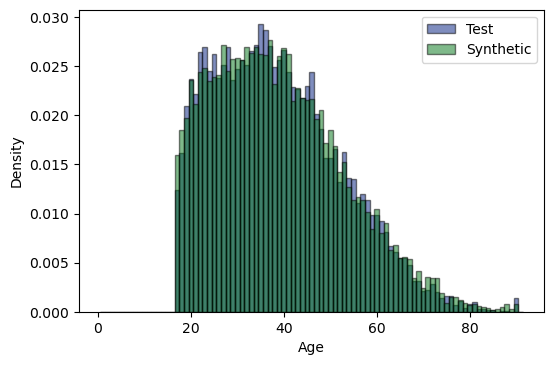

In [12]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark-palette")
plt.rcParams['axes.facecolor']='w'
plt.figure(dpi=100)
sColumn = 'age'
y = dfTotalTestData[sColumn].values
z = dfSynthOrig[sColumn].values
bins = np.linspace(0.5, 91.5, 92)
plt.hist(y, bins, alpha = 0.5, density = True, label = "Test", ec='black')
plt.hist(z, bins, alpha = 0.5, density = True, label = "Synthetic", ec='black')
plt.legend(loc='upper right')
plt.xlabel('Age')
plt.ylabel("Density")
plt.show()

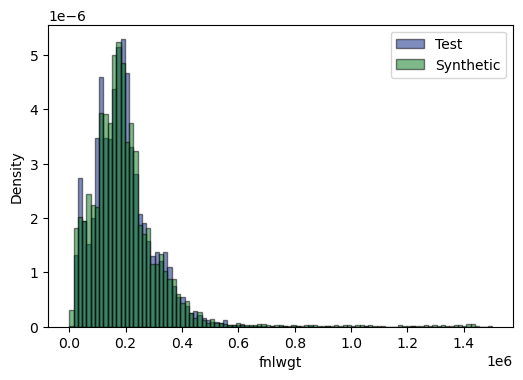

In [13]:
plt.figure(dpi=100)
sColumn = 'fnlwgt'
y = dfTotalTestData[sColumn].values
z = dfSynthOrig[sColumn].values
bins = np.linspace(0, 1500000, 100)
plt.hist(y, bins, alpha = 0.5, density = True, label = "Test", ec='black')
plt.hist(z, bins, alpha = 0.5, density = True, label = "Synthetic", ec='black')
plt.legend(loc='upper right')
plt.xlabel('fnlwgt')
plt.ylabel("Density")
plt.show()

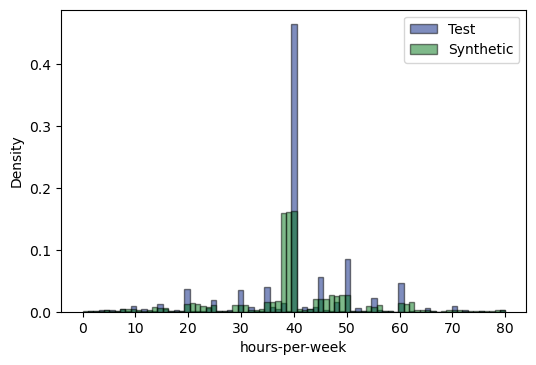

In [14]:
plt.figure(dpi=100)
sColumn = 'hours-per-week'
y = dfTotalTestData[sColumn].values
z = dfSynthOrig[sColumn].values
bins = np.linspace(0, 80, 80)
plt.hist(y, bins, alpha = 0.5, density = True, label = "Test", ec='black')
plt.hist(z, bins, alpha = 0.5, density = True, label = "Synthetic", ec='black')
plt.legend(loc='upper right')
plt.xlabel('hours-per-week')
plt.ylabel("Density")
plt.show()

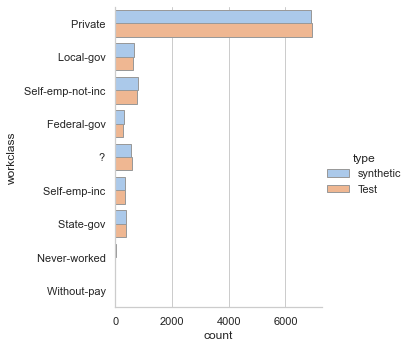

In [15]:
import seaborn as sns
sns.set_theme(style="whitegrid")
dfTemp1 = pd.DataFrame.from_dict({'workclass': dfSynthOrig['workclass'].values, 'type': ["synthetic" for _ in range(10000)]})
dfTemp2 = pd.DataFrame.from_dict({'workclass': dfTotalTestData['workclass'].values, 'type': ["Test" for _ in range(10000)]})
dfPlotData = pd.concat( [dfTemp1, dfTemp2])
sns.catplot(
    data=dfPlotData, y="workclass", hue="type", kind="count",
    palette="pastel", edgecolor=".6",
)

Correlation plots

Text(0.5, 173.5119047619047, 'FTST')

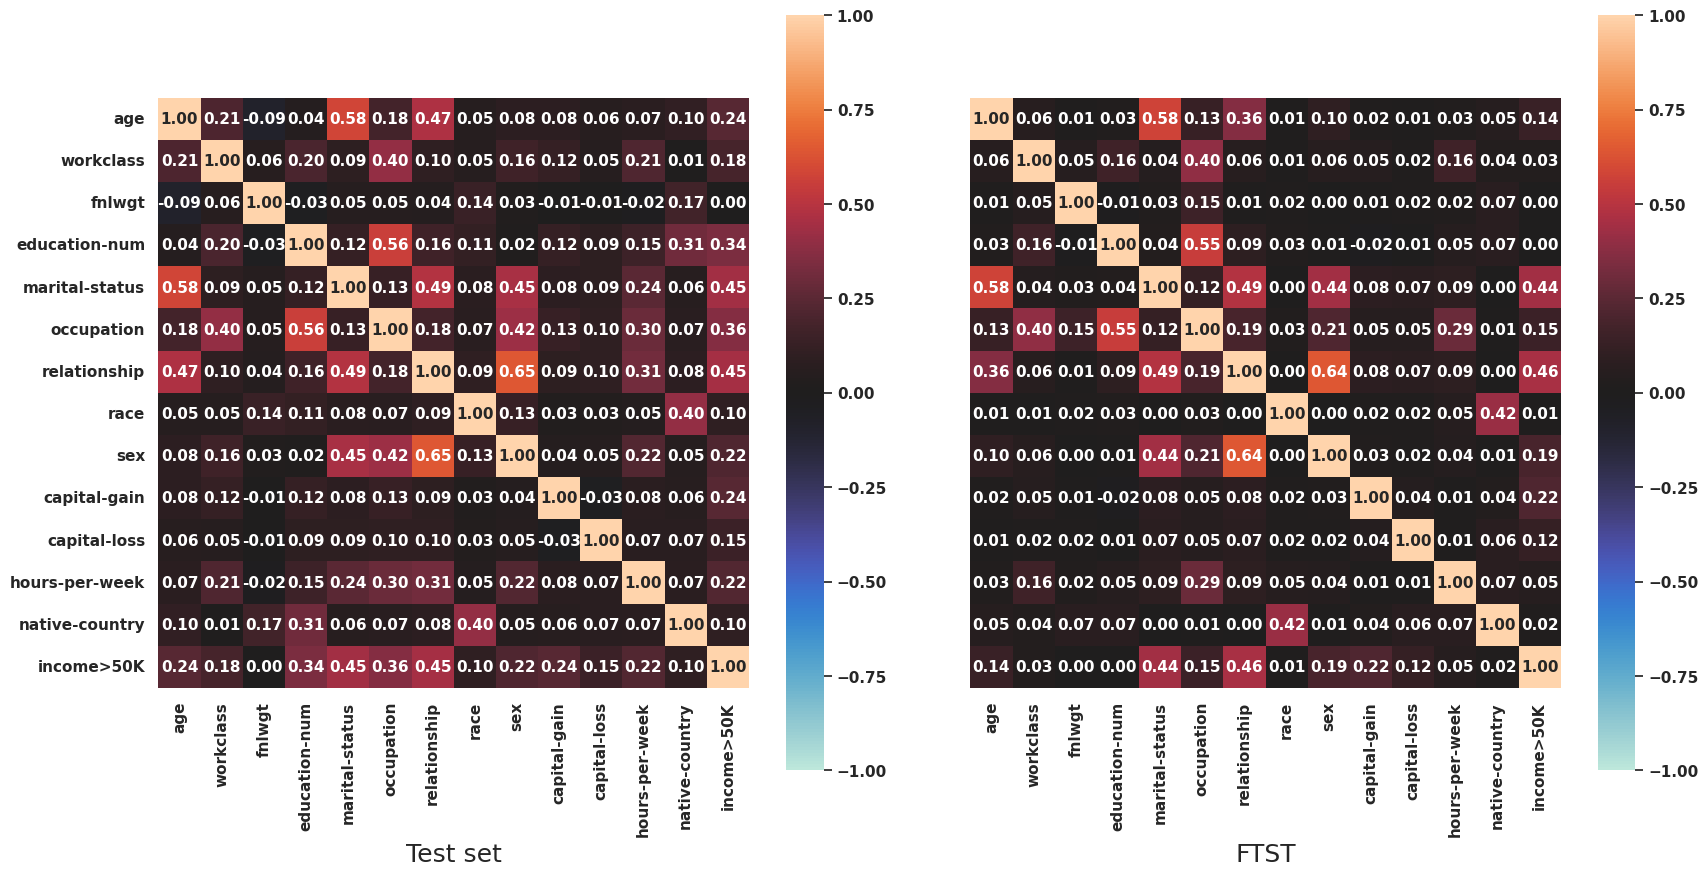

In [23]:
from dython.nominal import associations

#subplots
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize = (20,10), dpi = 100)

fig.subplots_adjust(hspace=0.1, wspace=0.1)
for a in axes.flatten():
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_aspect('equal')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
ax1, ax2= axes.flatten()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 11}
plt.rc('font', **font)
plt.rc('axes', labelsize=16)

associations(dfTotalTestData, ax = ax1, plot = False, cbar = True)
ax1.set_xlabel('Test set', fontsize = 18)
associations(dfSynthOrig, ax = ax2,  plot = False, cbar = True)
ax2.set_xlabel('FTST', fontsize = 18)



### Evaluation using Evaluation class

In [33]:
#define object
fedAllInOnePGM = FedAllInOnePGM(dMu = dMu, rng = rng, bVerbose=True, iMaxRoundsNumerical=4, bCombineLevels=False)
fedAdapIterPGM = FedAdapIterPGM(dMu = dMu, rng = rng, bVerbose=True, iMaxRoundsNumerical=4, iMaxDegree=3, bCombineLevels=True)
fedDPCTGAN = FedDPCTGAN(dMu = dMu, rng = rng, bVerbose=True, iSteps = 2, sLoss="cross-entropy", iDiscrUpdatesPerStep = 1, iGenUpdatesPerStep = 1, sDevice = "cpu", sClientOpt = "Adam")

#fit model. Fitting also create the federated dataset, so we also supply diMinMaxinfo, diCatUnqiqueValuesInfo and lDataTypes.
# model is the graphical model. fedDataset contains the discritized data and other info on the federated dataset.
modelAllInOne, fedDataset1 = fedAllInOnePGM.fit(lClientTrainDataRaw, diMinMaxInfo = diMinMaxInfo, diCatUniqueValuesInfo = diCatUniqueValuesInfo, lDataTypes = lDataTypes)
modelAdapIterPGM, fedDataset2 = fedAdapIterPGM.fit(lClientTrainDataRaw, diMinMaxInfo = diMinMaxInfo, diCatUniqueValuesInfo = diCatUniqueValuesInfo, lDataTypes = lDataTypes)
diResults, fedGANDataset = fedDPCTGAN.fit(lClientTrainDataRaw,  diMinMaxInfo = diMinMaxInfo, diCatUniqueValuesInfo = diCatUniqueValuesInfo, lDataTypes = lDataTypes, delimiterInfo= delimiterInfo) #delimiterInfo needed for MSN

start discritization and initial measurement
start initial estimation
start second selection step
start final estimation
Total clique size: 1010
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		1296.11		1635.11		0.00
50.00		0.81		905.95		529.60		0.00
100.00		1.56		851.39		462.84		0.00
150.00		2.35		838.98		444.20		0.00
200.00		3.19		835.47		440.17		0.00
250.00		4.12		833.07		438.42		0.00
300.00		4.89		832.30		437.64		0.00
350.00		5.59		832.35		437.16		0.00
400.00		6.38		831.32		436.87		0.00
450.00		7.24		831.13		436.68		0.00
500.00		8.08		831.32		436.55		0.00
550.00		8.94		831.42		436.46		0.00
600.00		9.77		831.22		436.39		0.00
650.00		10.51		831.02		436.33		0.00
Convergence achieved after: 700 iterations
start discritization and initial measurement
start initial estimation
Start initial model estimation
End initial model estimation
Squared Privacy Budget used: 35.0%
End iteration: 1. Squared Privacy Budget used: 35.714%. Measured marginal = ('workclass', 'sex')
double (squar

C:\Users\erkjrv\Anaconda3\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Communication Round: 1, Steps: 2, Squared train priv budget prop used: 100.0, GenLoss: -2.484, CondLoss =  9.6785, ModeLoss: 18.059, DiscrLoss: 5.5745


In [36]:
#generate 10 synthetic datasets for all
iRep = 10
lSynthGAN = []
lSynthMGFIGS = []
lSynthMGFSTS = []

for i in range(iRep):
    print(f"generate dataset: {i}")
    #Gan dataset
    lSynthGAN.append(fedDPCTGAN.synthetic_data(device = 'cpu', iRows = 10000))

    #FIGS dataset
    synhtMGFigsTemp = modelAdapIterPGM.synthetic_data(rows = 10000).df
    lSynthMGFIGS.append(FedDataset.transform_to_original_space(synhtMGFigsTemp , lDataTypes, diBins = fedDataset2.diBins, diDefaultBins = fedDataset2.diBins, delimiterInfo = delimiterInfo, rng = rng)) 

    #FSTS dataset
    synhtMGFstsTemp = modelAllInOne.synthetic_data(rows = 10000).df
    lSynthMGFSTS.append(FedDataset.transform_to_original_space(synhtMGFstsTemp , lDataTypes, diBins = fedDataset2.diBins, diDefaultBins = fedDataset2.diBins, delimiterInfo = delimiterInfo, rng = rng)) 


0
1
2
3
4
5
6
7
8
9


Set evaluation objects

In [38]:
#get eval objects
evalObjectGAN = Evaluation(lSynthGAN, dfTotalTrainData, dfTotalTestData, lDataTypes=lDataTypes, fedDataset=fedGANDataset, sSynthType = "original", sEvalType = "original")
evalObjectMGFIGS = Evaluation(lSynthMGFIGS, dfTotalTrainData, dfTotalTestData, lDataTypes=lDataTypes, fedDataset=fedGANDataset, sSynthType = "original", sEvalType = "original")
evalObjectMGFSTS = Evaluation(lSynthMGFSTS, dfTotalTrainData, dfTotalTestData, lDataTypes=lDataTypes, fedDataset=fedGANDataset, sSynthType = "original", sEvalType = "original")
   

Get marginal errors

In [40]:
#get marg errors
vResGAN = evalObjectGAN.marginalError(iMargOrder=2)
vResMGFIGS = evalObjectMGFIGS.marginalError(iMargOrder=2)
vResMGFSTS = evalObjectMGFSTS.marginalError(iMargOrder=2)

print(f"""
Mean error GAN: {round(np.mean(vResGAN),3)} ({round(np.std(vResGAN),5)})
Mean error FIG: {round(np.mean(vResMGFIGS),3)} ({round(np.std(vResMGFIGS),5)})
Mean error FST: {round(np.mean(vResMGFSTS),3)} ({round(np.std(vResMGFSTS),5)})
""")


Mean error GAN: 0.623 (0.00079)
Mean error FIG: 0.15 (0.00051)
Mean error FST: 0.158 (0.00051)



GET RF regression accuracy and BSS

In [43]:
mResGAN = evalObjectGAN.discriminator(sModel = "randomforest")
mResMGFIGS = evalObjectMGFIGS.discriminator(sModel = "randomforest")
mResMGFSTS = evalObjectMGFSTS.discriminator(sModel = "randomforest")

print(f"""
Mean Acc GAN: {round(np.mean(mResGAN[:,0]),3)} ({round(np.std(mResGAN[:,0]),5)})
Mean Acc FIG: {round(np.mean(mResMGFIGS[:,0]),3)} ({round(np.std(mResMGFIGS[:,0]),5)})
Mean Acc FST: {round(np.mean(mResMGFSTS[:,0]),3)} ({round(np.std(mResMGFSTS[:,0]),5)})

Mean BSS GAN: {round(np.mean(1.0 + 4.0*mResGAN[:,1]),3)} ({round(np.std(1.0 + 4.0*mResGAN[:,1]),5)})
Mean BSS FIG: {round(np.mean(1.0 + 4.0*mResMGFIGS[:,1]),3)} ({round(np.std(1.0 + 4.0*mResMGFIGS[:,1]),5)})
Mean BSS FST: {round(np.mean(1.0 + 4.0*mResMGFSTS[:,1]),3)} ({round(np.std(1.0 + 4.0*mResMGFSTS[:,1]),5)})
""")


Mean Acc GAN: 0.991 (0.00038)
Mean Acc FIG: 0.832 (0.00339)
Mean Acc FST: 0.837 (0.00316)

Mean BSS GAN: 0.962 (0.00076)
Mean BSS FIG: 0.487 (0.00438)
Mean BSS FST: 0.505 (0.0052)

